# Data Acquisition

In [1]:
import matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import cityImage as ci, regions as ur
import warnings
warnings.simplefilter(action="ignore")

pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None
%matplotlib inline

C:\Users\gfilo\AppData\Local\Temp\ipykernel_19112\3967664916.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd


In [2]:
place = 'Boston, MA'
epsg = 26986
city_name = 'Boston'
crs = 'EPSG'+str(epsg)
input_path = 'data/'+city_name

## Downloading the Street Network

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
download_method = 'OSMplace'
distance = None
nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)

In [ ]:
"""
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
"""
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                                            self_loops = True, same_uv_edges = True)

## Downloading the Barriers

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)
* *Polygon*

In [10]:
# define method and create envelope with wgs coordinate system
download_method = 'polygon'
place = ci.envelope_wgs(edges_graph)
distance = None
barriers = ci.get_barriers(place, download_method = 'polygon', distance = None, epsg = epsg)

In [24]:
road_barriers = ci.road_barriers(place, download_method, epsg = epsg, include_primary = False, include_secondary = False)
water_barriers = ci.water_barriers(place, download_method, lakes_area = 3000, epsg = epsg)
railway_barriers = ci.railway_barriers(place, download_method, epsg = epsg, keep_light_rail = False)
barriers = pd.concat([road_barriers, water_barriers, railway_barriers])
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

### Visualisation

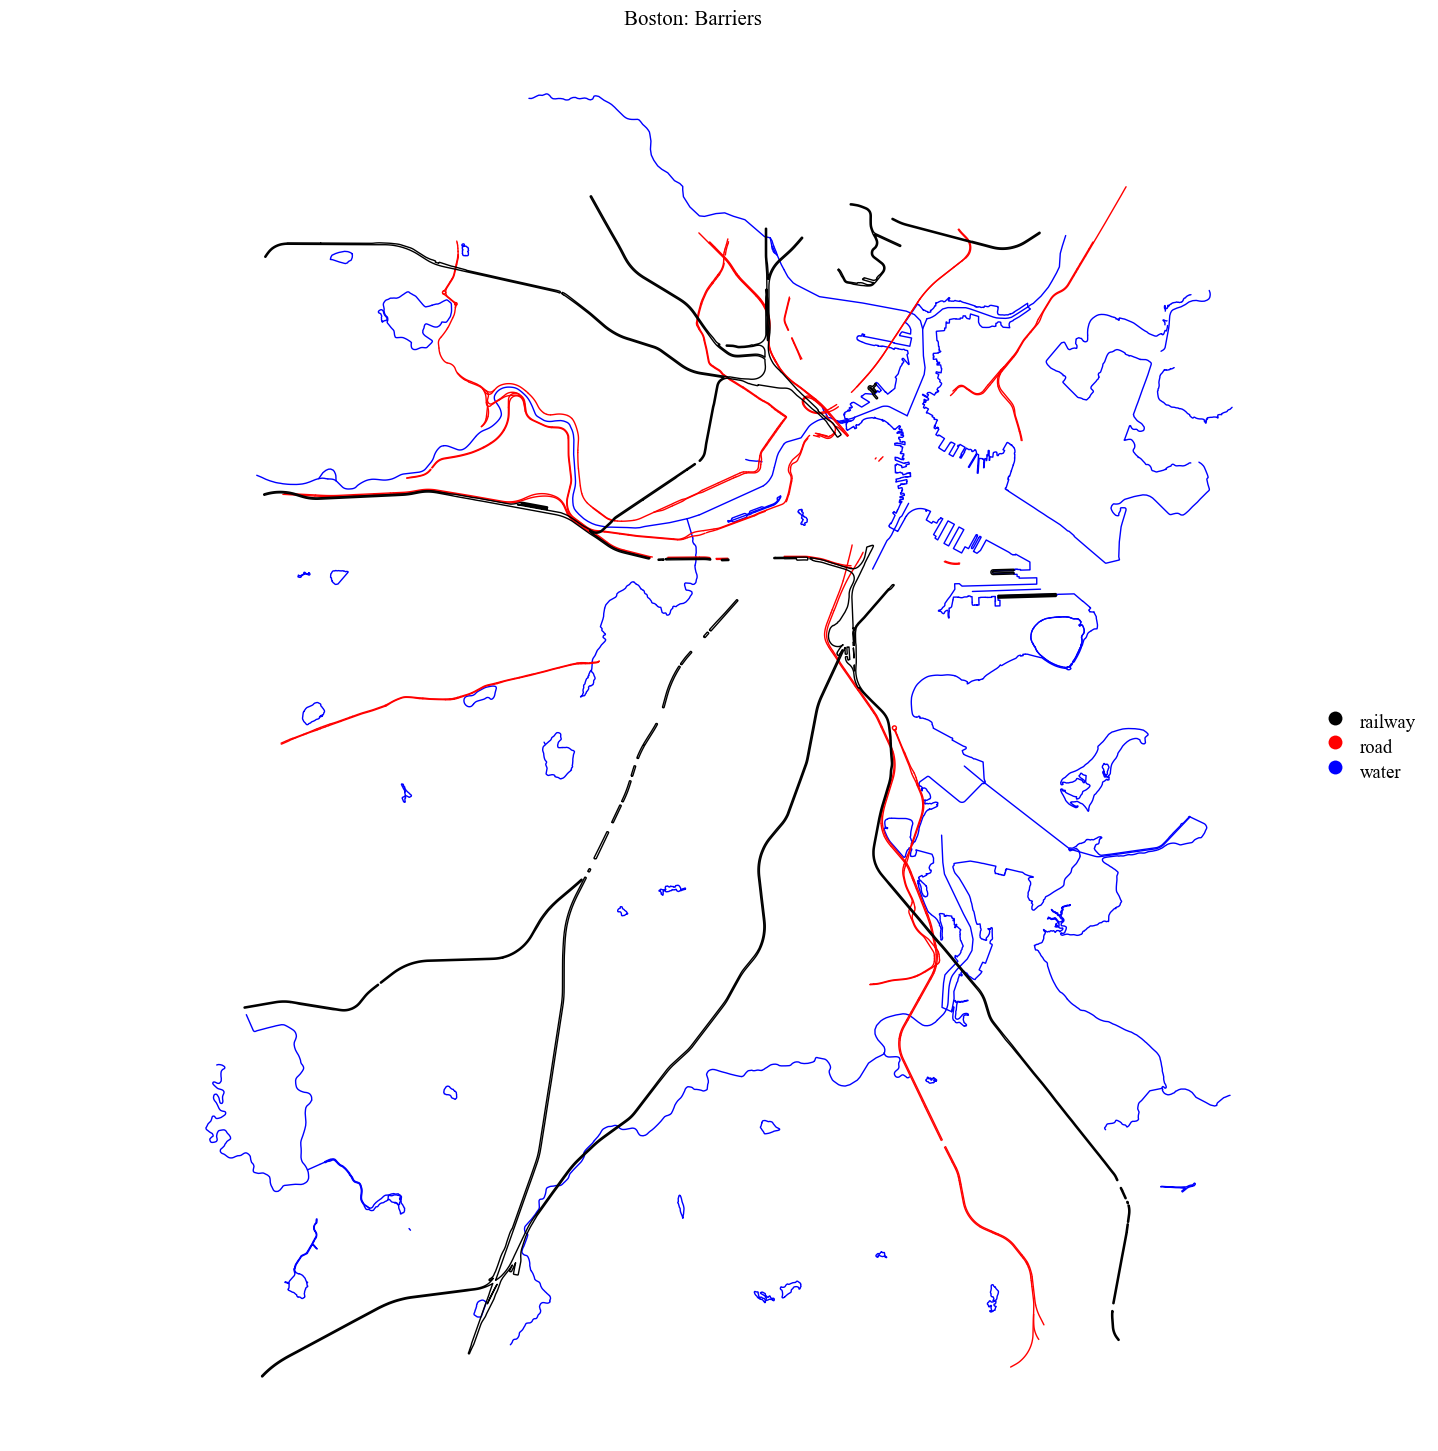

In [32]:
from matplotlib.colors import LinearSegmentedColormap
barriers.sort_values(by = 'barrier_type', ascending = False, inplace = True) 
colors = ['black', 'red', 'blue']

cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(gdf = barriers, column = 'barrier_type', black_background = False, title = city_name+': Barriers', legend = True, cmap = cmap)

In [30]:
barriers.to_file(input_path+"_barriers.gpkg", driver='GPKG')

In [33]:
# after manual adjustments
barriers = gpd.read_file(input_path+"_barriers.gpkg", driver='GPKG')

## Assigning barriers to street segments

In [34]:
# crossing any kind of barrier but parks
envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(envelope)]
edges_graph = ci.assign_structuring_barriers(edges_graph, barriers_within)

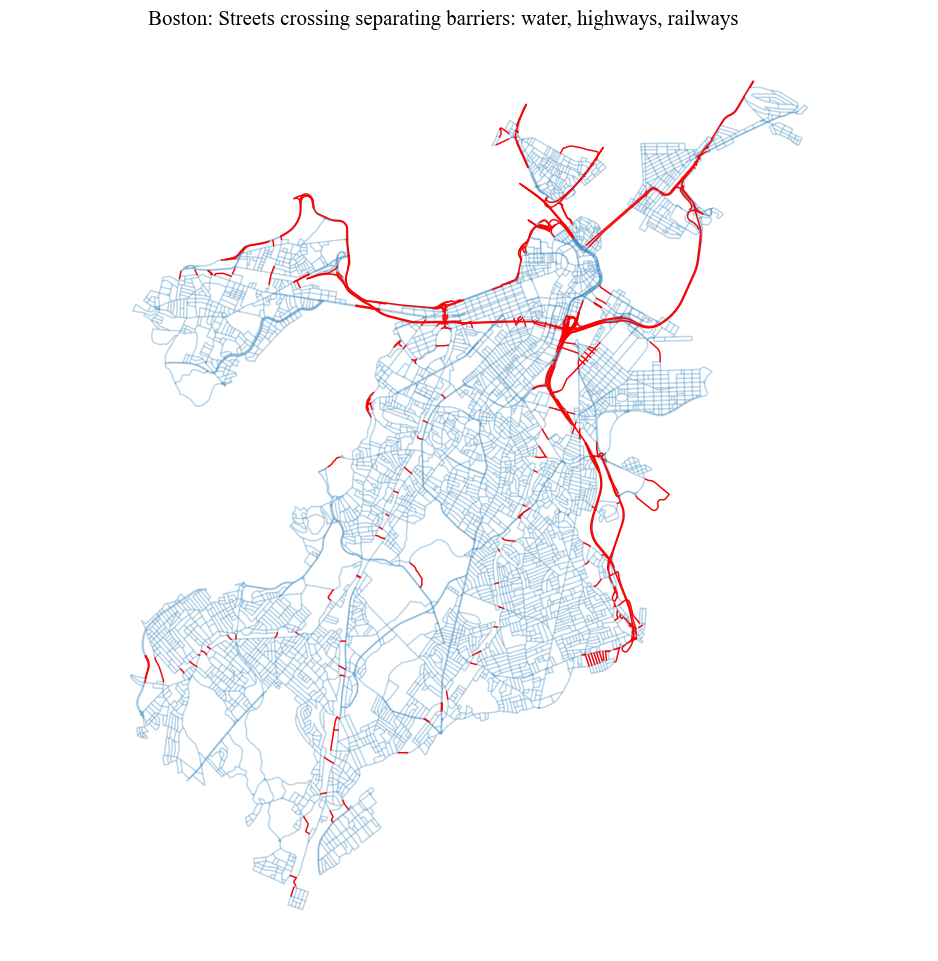

In [35]:
tmp = edges_graph[edges_graph.sep_barr == True].copy()
fig = ci.plot_gdf(tmp, black_background = False, figsize = (10,10), color = 'red', 
                  title = city_name+': Streets crossing separating barriers: water, highways, railways',
                  base_map_gdf = edges_graph, base_map_alpha = 0.3, legend = False)

In [36]:
## removing streets segments which are crossing barriers
edges_graph_nb = edges_graph[edges_graph.sep_barr != True].copy()
nodes_graph_nb, edges_graph_nb = ci.clean_network(nodes_graph, edges_graph_nb, dead_ends = True,
                                remove_islands = False, self_loops = False, same_vertexes_edges = True)

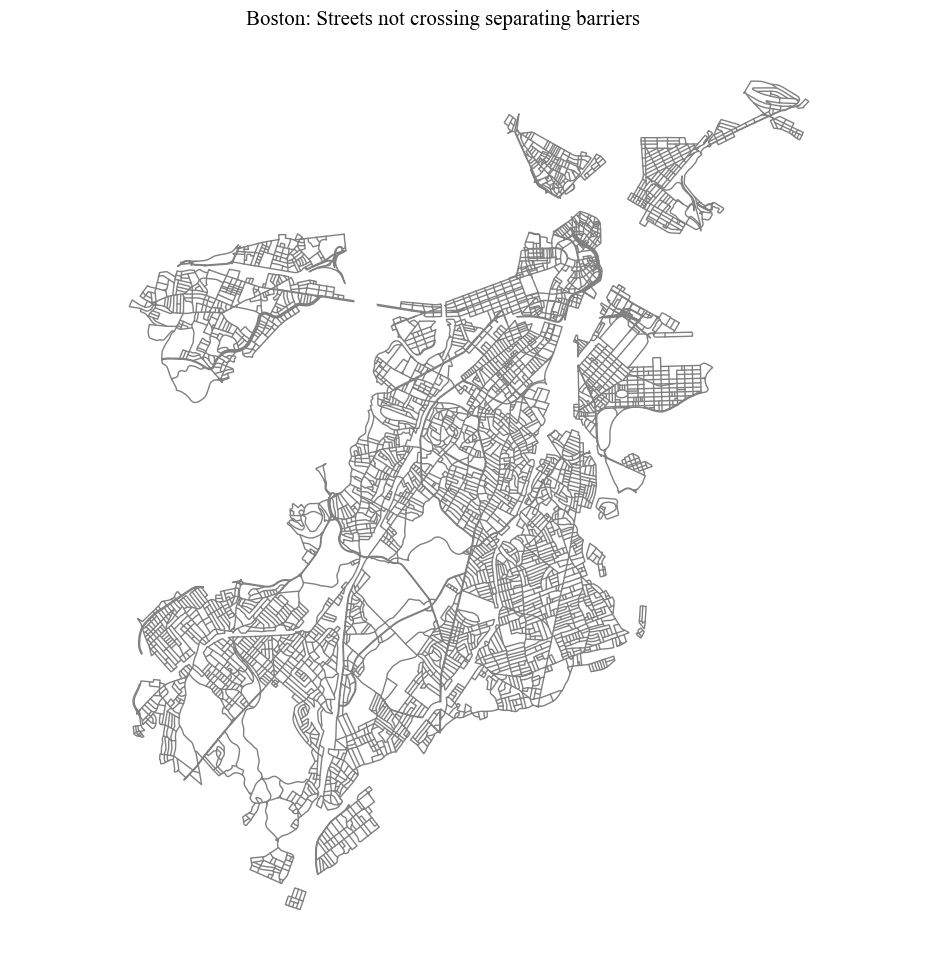

In [37]:
fig = ci.plot_gdf(edges_graph_nb, black_background = False, figsize = (10,10), color = 'gray', 
             title = city_name+': Streets not crossing separating barriers', legend = False)

## Exporting

In [49]:
# primal Graph
nodes_graph.to_file(input_path+'_nodes.gpkg',  driver='GPKG')
edges_graph.to_file(input_path+"_edges.gpkg", driver='GPKG')
nodes_graph_nb.to_file(input_path+"_nodes_noBarriers.gpkg", driver='GPKG')
edges_graph_nb.to_file(input_path+"_edges_noBarriers.gpkg", driver='GPKG')

# dual graph
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
nodesDual_graph.drop(['intersecting'], axis = 1, errors = 'ignore').to_file(input_path+"_nodesDual.gpkg", driver='GPKG')
edgesDual_graph.to_file(input_path+"_edgesDual.gpkg", driver='GPKG')

nodesDual_graph_nb, edgesDual_graph_nb = ci.dual_gdf(nodes_graph_nb, edges_graph_nb, epsg)
nodesDual_graph_nb.drop(['intersecting'], axis = 1, errors = 'ignore').to_file(input_path+"_nodesDual_noBarriers.gpkg", driver='GPKG')
edgesDual_graph_nb.to_file(input_path+"_edgesDual_noBarriers.gpkg", driver='GPKG')

# barriers
barriers.to_file(input_path+"_barriers.gpkg", driver='GPKG')

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\graph.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_dual = pd.concat([edges_dual, new_row], ignore_index=True)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\graph.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_dual = pd.concat([edges_dual, new_row], ignore_index=True)
